<a href="https://colab.research.google.com/github/santoshrsarangi/tensorflow/blob/main/computer-vision/3_Data_Augumentation_Cats_vs_Dogs_Kaggle_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this exercise we will be working with the Dogs vs Cats dataset available in Kaggle. Do login to your Kaggle account (and if you dont have one then you can create it easily). Download your Kaggle API keys to local system and then continue here. Step 1: upload API keys to colab environment

In [1]:
from google.colab import files

In [2]:
r = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
# Change access to your Kaggle API so only current account has access to read/write
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c dogs-vs-cats

 98% 798M/812M [00:04<00:00, 271MB/s]
100% 812M/812M [00:04<00:00, 202MB/s]


In [7]:
!unzip --qq dogs-vs-cats.zip

In [8]:
!unzip --qq train.zip

In [9]:
!unzip --qq test1.zip

In [10]:
import os, shutil, pathlib

In [11]:
original_dir = pathlib.Path("train")
new_dir = pathlib.Path("cats_vs_dogs")

In [12]:
def create_folder_structure(name, start_index, end_index):

  for category in ("cat", "dog"):

    dir=new_dir / name / category
    os.makedirs(dir)

    file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

    for files in file_names:
      shutil.copyfile(src=original_dir / files, dst=dir / files)

In [13]:
create_folder_structure("train", start_index=0,end_index = 1000)
create_folder_structure("validation", start_index=1000, end_index=1500)
create_folder_structure("test", start_index=1500, end_index=2500 )

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [55]:
def getmodel(augument_data = True, dropout=True):

  inputs = keras.Input(shape=(180, 180, 3), name="InputLayer")

  if(augument_data):
    inputs_rf = layers.RandomFlip("horizontal", name="RF")(inputs)
    inputs_rr = layers.RandomRotation(0.1, name="RR")(inputs_rf)
    inputs_rz = layers.RandomZoom(0.2, name="RZ")(inputs_rr)

  #rescale the image to 1 - 255
  x = layers.Rescaling(scale=1./255, name="Rescaling_Layer")(inputs_rz)

  x = layers.Conv2D(filters=32, activation="relu", kernel_size=3, name="Conv2D1") (x)
  x = layers.MaxPool2D(pool_size=(2,2), name="MaxPool1")(x)

  x = layers.Conv2D(filters=64, activation="relu", kernel_size=3, name="Conv2D2") (x)
  x = layers.MaxPool2D(pool_size=(2,2), name="MaxPool2")(x)

  x = layers.Conv2D(filters=128, activation="relu", kernel_size=3, name="Conv2D3") (x)
  x = layers.MaxPool2D(pool_size=(2,2), name="MaxPool3")(x)

  x = layers.Conv2D(filters=256, activation="relu", kernel_size=3, name="Conv2D4") (x)
  x = layers.MaxPool2D(pool_size=(2,2), name="MaxPool4")(x)

  x = layers.Conv2D(filters=256, activation="relu", kernel_size=3, name="Conv2D5") (x)
  
  x = layers.Flatten(name="Flatten")(x)

  #if(dropout):
  x = layers.Dropout(0.5)(x)

  outputs = layers.Dense(1, activation="sigmoid", name="OutputLayer")(x)

  model = keras.Model(inputs, outputs, name="CnDModel")

  model.compile(optimizer="rmsprop",
                loss="binary_crossentropy",
                metrics = ["accuracy"])
  
  return model

In [56]:
model = getmodel(augument_data=True, dropout=False)
model.summary()

Model: "CnDModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 180, 180, 3)]     0         
                                                                 
 RF (RandomFlip)             (None, 180, 180, 3)       0         
                                                                 
 RR (RandomRotation)         (None, 180, 180, 3)       0         
                                                                 
 RZ (RandomZoom)             (None, 180, 180, 3)       0         
                                                                 
 Rescaling_Layer (Rescaling)  (None, 180, 180, 3)      0         
                                                                 
 Conv2D1 (Conv2D)            (None, 178, 178, 32)      896       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 89, 89, 32)        0  

In [30]:
from keras import utils
from tensorflow.keras.utils import image_dataset_from_directory

In [31]:
train_dataset = image_dataset_from_directory(new_dir / "train", batch_size=32, image_size=(180, 180))

Found 2000 files belonging to 2 classes.


In [32]:
validation_dataset = image_dataset_from_directory(new_dir / "validation", batch_size=32, image_size=(180, 180))

Found 1000 files belonging to 2 classes.


In [33]:
test_dataset = image_dataset_from_directory(new_dir / "test", batch_size=32, image_size=(180, 180))

Found 2000 files belonging to 2 classes.


In [34]:
it = iter(train_dataset)

d, l = next(it)

In [35]:
d.shape

TensorShape([32, 180, 180, 3])

In [36]:
l.shape

TensorShape([32])

In [37]:
mycallbacks = [keras.callbacks.ModelCheckpoint(filepath="cats_vs_dogs_with_data_aug.keras", monitor="val_loss", save_best_only=True)]

In [38]:
trainin_history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=mycallbacks)

Epoch 1/30
63/63 [==============================] - 19s 81ms/step - loss: 0.7264 - accuracy: 0.5245 - val_loss: 0.6915 - val_accuracy: 0.5110
Epoch 2/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6972 - accuracy: 0.5470 - val_loss: 0.6904 - val_accuracy: 0.5020
Epoch 3/30
63/63 [==============================] - 5s 68ms/step - loss: 0.6823 - accuracy: 0.5905 - val_loss: 0.6758 - val_accuracy: 0.5940
Epoch 4/30
63/63 [==============================] - 4s 67ms/step - loss: 0.6632 - accuracy: 0.6240 - val_loss: 0.6805 - val_accuracy: 0.5770
Epoch 5/30
63/63 [==============================] - 5s 68ms/step - loss: 0.6667 - accuracy: 0.6305 - val_loss: 1.4849 - val_accuracy: 0.5040
Epoch 6/30
63/63 [==============================] - 5s 69ms/step - loss: 0.6431 - accuracy: 0.6440 - val_loss: 0.6110 - val_accuracy: 0.6560
Epoch 7/30
63/63 [==============================] - 5s 80ms/step - loss: 0.6086 - accuracy: 0.6625 - val_loss: 0.6121 - val_accuracy: 0.6530
Epoch 8/30
6

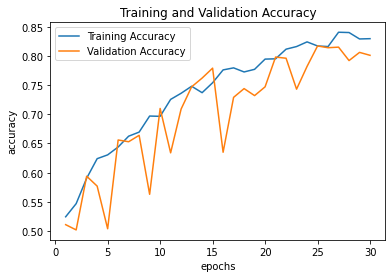

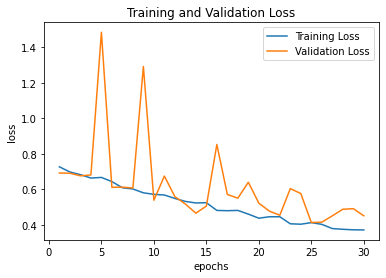

In [39]:
import matplotlib.pyplot as plt
epochs = range(1, 31)
plt.plot(epochs, trainin_history.history["accuracy"], label="Training Accuracy")
plt.plot(epochs, trainin_history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy")

plt.figure()
plt.plot(epochs, trainin_history.history["loss"], label="Training Loss")
plt.plot(epochs, trainin_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and Validation Loss")

plt.show()

In [60]:
#load the model that was saved
test_model = keras.models.load_model("cats_vs_dogs_with_data_aug.keras")

In [67]:
files.download("cats_vs_dogs_with_data_aug.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
test_loss, test_accuracy = test_model.evaluate(test_dataset)

63/63 [==============================] - 3s 34ms/step - loss: 0.4351 - accuracy: 0.8085


In [62]:
print(f"Testing accuracy: {test_accuracy: .4f}")

Testing accuracy:  0.8085


In [63]:
print(f"Testing loss: {test_loss: .3f}")

Testing loss:  0.435


In [57]:
model = getmodel(augument_data=True, dropout=True)

In [58]:
trainin_history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=mycallbacks)

Epoch 1/100
63/63 [==============================] - 6s 71ms/step - loss: 0.7446 - accuracy: 0.5190 - val_loss: 0.6913 - val_accuracy: 0.5780
Epoch 2/100
63/63 [==============================] - 5s 68ms/step - loss: 0.6969 - accuracy: 0.5200 - val_loss: 0.6742 - val_accuracy: 0.5540
Epoch 3/100
63/63 [==============================] - 5s 68ms/step - loss: 0.6895 - accuracy: 0.5495 - val_loss: 0.6813 - val_accuracy: 0.5280
Epoch 4/100
63/63 [==============================] - 4s 67ms/step - loss: 0.6705 - accuracy: 0.6095 - val_loss: 1.2984 - val_accuracy: 0.5260
Epoch 5/100
63/63 [==============================] - 4s 67ms/step - loss: 0.6471 - accuracy: 0.6350 - val_loss: 0.6383 - val_accuracy: 0.6070
Epoch 6/100
63/63 [==============================] - 5s 68ms/step - loss: 0.6155 - accuracy: 0.6625 - val_loss: 0.6037 - val_accuracy: 0.6860
Epoch 7/100
63/63 [==============================] - 5s 80ms/step - loss: 0.6052 - accuracy: 0.6935 - val_loss: 0.7128 - val_accuracy: 0.6460
Epoch 

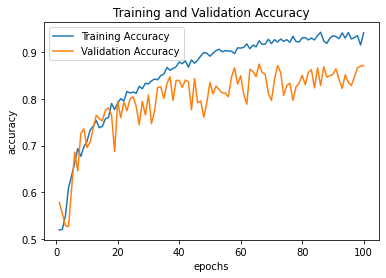

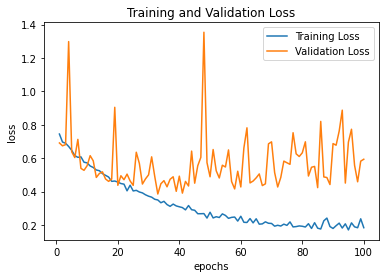

In [59]:
import matplotlib.pyplot as plt
epochs = range(1, 101)
plt.plot(epochs, trainin_history.history["accuracy"], label="Training Accuracy")
plt.plot(epochs, trainin_history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy")

plt.figure()
plt.plot(epochs, trainin_history.history["loss"], label="Training Loss")
plt.plot(epochs, trainin_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and Validation Loss")

plt.show()